<a href="https://colab.research.google.com/github/cayleighhaag10/DeployModelOnImages/blob/main/Deploy_Model_on_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration of model on N images.

In this notebook, we will demonstrate the model's detection and evalutation, including post-processing, for a small subset of images, the number of which will be inputted by the user below, and (optionally) for a specific year (see'Detection').

In [36]:
# We will install the required libraries
!pip install numpy pandas matplotlib opencv-python torch torchvision ultralytics

# We will also clone our GitHub Repository (first removing the previously cloned repository)
!rm -rf /content/DeployModelOnImages
!git clone https://github.com/cayleighhaag10/DeployModelOnImages.git

Cloning into 'DeployModelOnImages'...
remote: Enumerating objects: 56478, done.
remote: Counting objects: 100% (56478/56478), done.
remote: Compressing objects: 100% (56445/56445), done.
remote: Total 56478 (delta 28), reused 56478 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (56478/56478), 764.34 MiB | 41.59 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (73557/73557), done.


In [37]:
# Import the necessary libraries
from ultralytics import YOLO
import os
import glob
import pandas as pd
import shutil
import json
import geopandas as gpd
from shapely import wkt
import random

## Detection

We will use pre-computed weights to detect aqaducts for our image sampling.

---


The following code will load the pre-comupted weights that we will use for detection. It will also load  the images that we will run detection and evaluation for.

In [38]:
# Load data.
weights = "/content/DeployModelOnImages/weights_for_deploying_model.pt"
model = YOLO(weights)

# Load images.
folder = '/content/DeployModelOnImages/images'

Please supply the number images you would like to run detection on. This number should be between 1 - 100. Please also input the year you would like to run detection on (correct inputs are are '1974', '1982', '1984', or '2019'). If you would like to deploy the model on images from a random sample of the years, input '0'.

In [45]:
# USER PROVIDED INPUTS
# correct inputs are integers, 1 - 100
num_images = 10
# correct inputs are integers, either '0', '1974', '1982', '1984', or '2019'
year = 0

Now we will run this model on our images, which we will sample randomly according to user inputs (num_images and year). We will also display the results.


0: 256x256 8 shafts, 621.2ms
1: 256x256 (no detections), 621.2ms
2: 256x256 (no detections), 621.2ms
3: 256x256 (no detections), 621.2ms
4: 256x256 (no detections), 621.2ms
5: 256x256 (no detections), 621.2ms
6: 256x256 (no detections), 621.2ms
7: 256x256 (no detections), 621.2ms
8: 256x256 (no detections), 621.2ms
9: 256x256 (no detections), 621.2ms
Speed: 1.1ms preprocess, 621.2ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)
Results saved to /content/runs/detect/predict
1 label saved to /content/runs/detect/predict/labels


The model was run on 10 images.
These images were sampled from 1974, 1982, 1984, and 2019.


/content/DeployModelOnImages/images/1982_14983.jpg


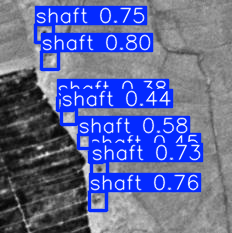

/content/DeployModelOnImages/images/1984_6858.jpg


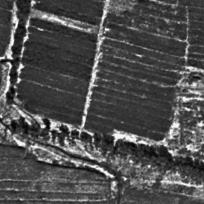

/content/DeployModelOnImages/images/2019_444.jpg


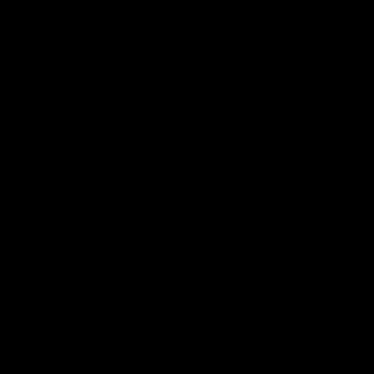

/content/DeployModelOnImages/images/1984_13416.jpg


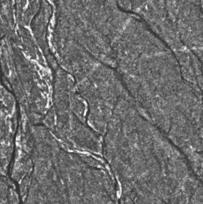

/content/DeployModelOnImages/images/2019_2396.jpg


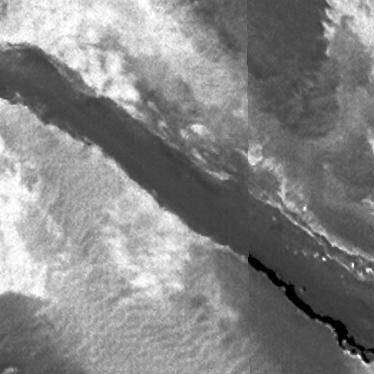

/content/DeployModelOnImages/images/2019_11637.jpg


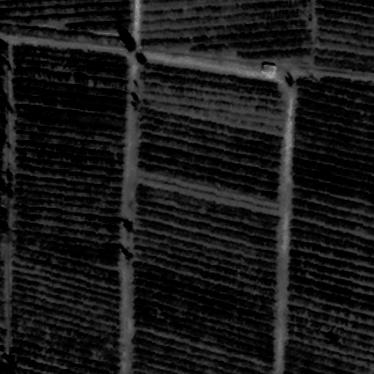

/content/DeployModelOnImages/images/2019_4985.jpg


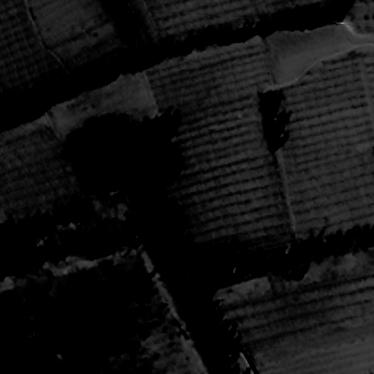

/content/DeployModelOnImages/images/1982_496.jpg


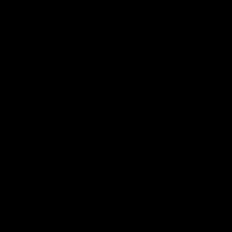

/content/DeployModelOnImages/images/1982_6030.jpg


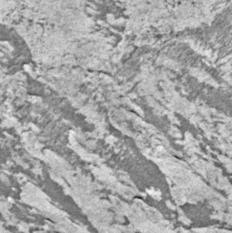

/content/DeployModelOnImages/images/1974_18369.jpg


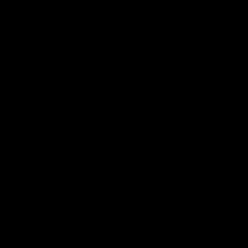

In [46]:
# If the user input for number of images is too large, set to a default value.
if (num_images <= 0 or num_images > 100):
  num_images = 10

# This will contain random sample of num_images images, from a specified year.
image_paths = []
if (year == 1974 or year == 1982 or year == 1984 or year == 2019):
  # get all images whose prefix is a certain year
  all_images = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if os.path.isfile(os.path.join(folder, f)) and f.startswith(str(year))]

  # take a random sample of those images of size num_images
  image_paths = random.sample(all_images, num_images)

else: # default case
  # get all images
  all_images = [os.path.join(folder, f) for f in os.listdir(folder)]

  # take a random sample of those images of size num_images
  image_paths = random.sample(all_images, num_images)

# Clear out previous runs
runs_dir = "/content/runs/detect"
if os.path.exists(runs_dir):
  shutil.rmtree(runs_dir)

# Run the model and save the .txt files and the confidence of each prediction
results = model(image_paths, save=True, save_txt=True, save_conf=True)
print("\n")

# Display results
print(f"The model was run on {num_images} images.")
if (year == 1974 or year == 1982 or year == 1984 or year == 2019):
  print(f"These images are from {year}.")
else:
  print("These images were sampled from 1974, 1982, 1984, and 2019.")

print("\n")
for r in results:
  print(r.path)
  r.show()

## Post-Processing

In post-processing, we will attempt to remove any duplicate classifications caused by overlapping file boundaries.

---


We will begin by combining the .csv files returned by running our model.

In [81]:
# Get all saved .txt files, with the following format
all_txts = glob.glob("/content/runs/detect/predict/labels/*.txt")

# Change the txt files to a DataFrame for ease of merging (done below)
dfs = []
for file in all_txts:
  # Get the contents of this .txt
  df = pd.read_csv(file, sep=" ", header=None)
  # Assign to columns of this DataFrame
  df.columns = ["class", "x_center", "y_center", "width", "height", "confidence"]
  # The name of this image is the last file name, without the appending .txt
  df["image"] = os.path.basename(file).replace(".txt", "")

  # Append to the data frame
  dfs.append(df)

# Merge and save the results
combined = pd.concat(dfs, ignore_index=True)
combined.to_csv("all_predictions.csv", index=False)

# Print the combined results (all classifications)
print(combined)

     class  x_center  y_center     width    height  confidence        image
0        0  0.604406  0.364849  0.092492  0.091323    0.792553  H1984_11480
1        0  0.606329  0.886568  0.077763  0.074117    0.791148  H1984_11480
2        0  0.711176  0.323930  0.085415  0.071372    0.787202  H1984_11480
3        0  0.464893  0.366638  0.072556  0.081370    0.772646  H1984_11480
4        0  0.552328  0.122158  0.070859  0.079113    0.768866  H1984_11480
..     ...       ...       ...       ...       ...         ...          ...
160      0  0.813549  0.550301  0.075844  0.083640    0.749206  H1982_11479
161      0  0.378865  0.675184  0.074023  0.071600    0.747958  H1982_11479
162      0  0.349711  0.740995  0.084325  0.082304    0.747781  H1982_11479
163      0  0.459698  0.965425  0.079725  0.069150    0.732359  H1982_11479
164      0  0.395181  0.968534  0.082527  0.062933    0.702977  H1982_11479

[165 rows x 7 columns]


We will now modify this DataFrame to be contained within seven columns, defined as follows:

*   year
*   numeric_id
*   confidence
*   top_bound_percentage
*   bottom_bound_percentage
*   left_bound_percentage
*   right_bound_percentage



In [82]:
# The resulting DataFrame to be returned
results = []
# The previously calculated predictions
df = pd.read_csv(f"all_predictions.csv")

# For each row (each prediction) in the combined csv
for i, row in df.iterrows():
  image_id = row[6]
  # Clean up the start of each year on the image id
  if (image_id[0] == "H"):
    image_id = image_id[1:]

  confidence = row[5]

  # Split the filename
  year, numeric_id = image_id.split("_")

  # Calculate the percentages
  x_center = row[1]
  y_center = row[2]
  width = row[3]
  height = row[4]

  top_pct = x_center - width/2
  bottom_pct = x_center + width/2
  left_pct = y_center - height/2
  right_pct = y_center + height/2

  # Append this information to results
  results.append({
      "year": year,
      "numeric_id": numeric_id,
      "confidence": confidence,
      "top_bound_percentage": top_pct,
      "bottom_bound_percentage": bottom_pct,
      "left_bound_percentage": left_pct,
      "right_bound_percentage": right_pct
    })

# Save results to a csv
output_df = pd.DataFrame(results)
output_df.to_csv("final_predictions.csv", index=False)

# Print the results
print(output_df)

     year numeric_id  confidence  top_bound_percentage  \
0    1984      11480    0.792553              0.558160   
1    1984      11480    0.791148              0.567448   
2    1984      11480    0.787202              0.668469   
3    1984      11480    0.772646              0.428615   
4    1984      11480    0.768866              0.516898   
..    ...        ...         ...                   ...   
160  1982      11479    0.749206              0.775627   
161  1982      11479    0.747958              0.341854   
162  1982      11479    0.747781              0.307549   
163  1982      11479    0.732359              0.419835   
164  1982      11479    0.702977              0.353918   

     bottom_bound_percentage  left_bound_percentage  right_bound_percentage  
0                   0.650652               0.319187                0.410511  
1                   0.645210               0.849510                0.923626  
2                   0.753883               0.288244                0.

/tmp/ipython-input-3602943518.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[6]
/tmp/ipython-input-3602943518.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confidence = row[5]
/tmp/ipython-input-3602943518.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_center = row[1]
/tmp/ipython-input-3602943518.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

The above top_bound_percentage, bottom_bound_percentage, left_bound_percentage, and right_bound_percentage are normalized as a percentage of the image width/height. We will now seek to translate these values to a global projection system, using a predefined grid. We will update the above DataFrame columns as follows:


*   top_bound_percentage -> global_top
*   bottom_bound_percentage -> global_bottom
*   left_bound_percentage -> global_left
*   right_bound_percentage -> global_right

We will also add a column: *wkt*, which will store the WKT polygon for the bounding box.



In [83]:
pred_df = pd.read_csv("final_predictions.csv")
grid_df = pd.read_csv("/content/drive/MyDrive/Example_deploy_model/grid.csv")

# Merge predictions with grid based on image_numeric_id and tile_id
merged_df = pred_df.merge(grid_df, left_on="numeric_id", right_on="tile_id", how="inner")

# Calculate the absolute coordinates for bounding boxes within the global map
results = []
for _, row in merged_df.iterrows():
  # Get the tile boundaries from the grid
  tile_left, tile_top, tile_right, tile_bottom = row["left"], row["top"], row["right"], row["bottom"]

  # Get the tile size
  tile_width = tile_right - tile_left
  tile_height = tile_bottom - tile_top

  # Convert relative percentages to absolute positions
  abs_left = tile_left + row["left_bound_percentage"] * tile_width
  abs_right = tile_left + row["right_bound_percentage"] * tile_width
  abs_top = tile_top + row["top_bound_percentage"] * tile_height
  abs_bottom = tile_top + row["bottom_bound_percentage"] * tile_height

  # Create WKT polygon (clockwise order)
  wkt_polygon = (
      f"POLYGON (({abs_left} {abs_top}, {abs_right} {abs_top}, {abs_right} {abs_bottom}, {abs_left} {abs_bottom}, {abs_left} {abs_top}))"
  )

  results.append({
        "year": row["year"],
        "numeric_id": row["numeric_id"],
        "confidence": row["confidence"],
        "global_left": abs_left,
        "global_right": abs_right,
        "global_top": abs_top,
        "global_bottom": abs_bottom,
        "wkt": wkt_polygon
    })

# Save results to a csv
output_df = pd.DataFrame(results)
output_df.to_csv("globally_mapped_predictions.csv", index=False)

# Print the results
print(output_df)


     year  numeric_id  confidence   global_left  global_right    global_top  \
0    1984       11480    0.792553  9.932042e+06  9.932065e+06  5.303480e+06   
1    1984       11480    0.791148  9.932178e+06  9.932197e+06  5.303477e+06   
2    1984       11480    0.787202  9.932034e+06  9.932052e+06  5.303451e+06   
3    1984       11480    0.772646  9.932044e+06  9.932065e+06  5.303513e+06   
4    1984       11480    0.768866  9.931981e+06  9.932002e+06  5.303490e+06   
..    ...         ...         ...           ...           ...           ...   
160  1982       11479    0.749206  9.932090e+06  9.932112e+06  5.303654e+06   
161  1982       11479    0.747958  9.932124e+06  9.932142e+06  5.303765e+06   
162  1982       11479    0.747781  9.932139e+06  9.932161e+06  5.303774e+06   
163  1982       11479    0.732359  9.932199e+06  9.932216e+06  5.303745e+06   
164  1982       11479    0.702977  9.932200e+06  9.932216e+06  5.303762e+06   

     global_bottom                                 

Now we will seek to remove all overlapping predictions, which occur due to the overlap of tile borders. We will remove any boxes that have a IoU (Jaccard) threshhold over 0.9.

In [71]:
IOU_THRESHOLD = 0.90

# This function will calculate the IoU (Jaccard) threshold
def pair_iou(geom_a, area_a, geom_b, area_b):
    inter = geom_a.intersection(geom_b)
    if inter.is_empty:
        return 0.0
    inter_area = inter.area
    union_area = area_a + area_b - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

In [84]:
# Load the WKT to a GeoDataFrame
df = pd.read_csv("globally_mapped_predictions.csv")
gdf = gpd.GeoDataFrame(df, geometry=df["wkt"].apply(wkt.loads), crs="EPSG:3857")

# Fix any invalid geometries and project to equal-area CRS for area math
gdf["geometry"] = gdf.geometry.apply(lambda g: make_valid(g) if g and not g.is_valid else g)
gdf = gdf.to_crs(3857)

# Precompute areas and spatial index
gdf["__area"] = gdf.geometry.area
sidx = gdf.sindex

# Sort indices by area, smallest to largest, so we only ever drop the smaller one
idx_sorted_small_to_large = gdf["__area"].sort_values().index.tolist()

to_drop = set()
areas = gdf["__area"]

for i in idx_sorted_small_to_large:
    # If we have already identified this idx to be dropped, continue
    if i in to_drop:
        continue

    geom_i = gdf.at[i, "geometry"]
    # If geometry is empty, add it to set to be dropped and continue
    if geom_i is None or geom_i.is_empty:
        to_drop.add(i)
        continue

    # Query bbox candidates, keep only strictly larger polygons
    cand_ids = list(sidx.intersection(geom_i.bounds))
    cand_ids = [j for j in cand_ids if j != i and areas.at[j] > areas.at[i]]

    # If any larger candidate is too similar, drop the smaller (i)
    for j in cand_ids:
        geom_j = gdf.at[j, "geometry"]
        if geom_j is None or geom_j.is_empty:
            continue

        # If centroid of a smaller polygon is inside a larger polygon, drop this smaller polygon
        if geom_i.centroid.within(geom_j):
            to_drop.add(i)
            break

        # If IoU exceeds the threshold, drop this smaller polygon
        iou = pair_iou(geom_i, area_i, geom_j, areas.at[j])
        if iou >= IOU_THRESHOLD:
            to_drop.add(i)
            break

# Keep all polygons that are not marked to be dropped
filtered = gdf.drop(index=list(to_drop)).copy()

# Update the csv
filtered_latlon = filtered.to_crs(3857)
filtered_latlon["wkt"] = filtered_latlon.geometry.to_wkt()
out_cols = [c for c in df.columns if c != "wkt"] + ["wkt"]
filtered_latlon[out_cols].to_csv("cleaned_predictions.csv", index=False)

# Print the results
df_results = pd.read_csv("cleaned_predictions.csv")
print(df_results)
print(f"Input polygons: {len(gdf)}")
print(f"Removed near-duplicates/smaller overlaps: {len(to_drop)}")
print(f"Kept: {len(filtered)}")


     year  numeric_id  confidence   global_left  global_right    global_top  \
0    1984       11480    0.792553  9.932042e+06  9.932065e+06  5.303480e+06   
1    1984       11480    0.791148  9.932178e+06  9.932197e+06  5.303477e+06   
2    1984       11480    0.787202  9.932034e+06  9.932052e+06  5.303451e+06   
3    1984       11480    0.772646  9.932044e+06  9.932065e+06  5.303513e+06   
4    1984       11480    0.768866  9.931981e+06  9.932002e+06  5.303490e+06   
..    ...         ...         ...           ...           ...           ...   
159  1982       11479    0.749206  9.932090e+06  9.932112e+06  5.303654e+06   
160  1982       11479    0.747958  9.932124e+06  9.932142e+06  5.303765e+06   
161  1982       11479    0.747781  9.932139e+06  9.932161e+06  5.303774e+06   
162  1982       11479    0.732359  9.932199e+06  9.932216e+06  5.303745e+06   
163  1982       11479    0.702977  9.932200e+06  9.932216e+06  5.303762e+06   

     global_bottom                                 

## Evaluation

We will now seek to ???

---

We begin by loading our DataFrame of cleaned predictions and getting rid of a column that we no longer need.


In [85]:
df = pd.read_csv("cleaned_predictions.csv")
df["geometry"] = df["wkt"].apply(wkt.loads)
# The geometry is set to be the column of shapely objects
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:3857")

# We no longer need the column that stores numeric_id
gdf.drop(columns=["numeric_id"], inplace=True, errors="ignore")
gdf["geometry"] = gdf["geometry"].buffer(0)

     year  confidence   global_left  global_right    global_top  \
0    1984    0.792553  9.932042e+06  9.932065e+06  5.303480e+06   
1    1984    0.791148  9.932178e+06  9.932197e+06  5.303477e+06   
2    1984    0.787202  9.932034e+06  9.932052e+06  5.303451e+06   
3    1984    0.772646  9.932044e+06  9.932065e+06  5.303513e+06   
4    1984    0.768866  9.931981e+06  9.932002e+06  5.303490e+06   
..    ...         ...           ...           ...           ...   
159  1982    0.749206  9.932090e+06  9.932112e+06  5.303654e+06   
160  1982    0.747958  9.932124e+06  9.932142e+06  5.303765e+06   
161  1982    0.747781  9.932139e+06  9.932161e+06  5.303774e+06   
162  1982    0.732359  9.932199e+06  9.932216e+06  5.303745e+06   
163  1982    0.702977  9.932200e+06  9.932216e+06  5.303762e+06   

     global_bottom                                                wkt  \
0     5.303456e+06  POLYGON ((9932042.0031 5303479.625778, 9932065...   
1     5.303457e+06  POLYGON ((9932177.765545 5303

We will now seek to give each aquaduct a unique feature ID.

In [ ]:
ATTEMPTING MODIFICATION